# Predicting Price

## With Size

### Neste projeto, estou trabalhando para um cliente que deseja criar um modelo que possa prever o preço de apartamentos na cidade de Buenos Aires — com foco em apartamentos que custam menos de US$ 400.000.

### Preparação dos dados

Importação das bibliotecas

In [1]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

Importação dos dados

In [2]:
df_inicial = pd.read_csv('/content/buenos-aires-real-estate-1.csv')
print("df_inicial shape:", df_inicial.shape)
df_inicial.head()

df_inicial shape: (8606, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
1,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,NaN,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,http://ramos-mejia.properati.com.ar/s7pd_venta...
2,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Cast...,"-34.6497002,-58.658073",410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,http://castelar-moron.properati.com.ar/11vgn_v...
3,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,"-34.5957086,-58.5669503",180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,http://tres-de-febrero.properati.com.ar/7f7u_v...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...


Explicação da função `wrangle()`

A função `wrangle(filepath)` tem como objetivo importar e filtrar os dados de imóveis contidos em um arquivo CSV. Ela realiza os seguintes passos:

1. **Importação dos dados**  
   Lê o arquivo CSV localizado no caminho informado e carrega os dados em um DataFrame.

2. **Filtragem por localização**  
   Mantém apenas os imóveis localizados na região de **"Capital Federal"**.

3. **Filtragem por tipo de imóvel**  
   Mantém apenas os imóveis do tipo **"apartment"** (apartamentos).

4. **Filtragem por preço**  
   Exclui os imóveis com preço acima de **400 mil dólares**.

5. **Filtragem por área útil**  
   Remove os imóveis com área útil fora do intervalo entre o **10º e o 90º percentis** da variável `surface_covered_in_m2`, eliminando valores extremos (outliers).

6. **Retorno do DataFrame limpo**  
   A função retorna apenas os imóveis que atendem a todos os critérios anteriores, prontos para análise ou modelagem.


In [29]:
def wrangle(filepath):
    #Import CVS
    df = pd.read_csv(filepath, sep=';')

    # Subset to properties in 'Capital Federal'
    mask_ba = df['place_with_parent_names'].str.contains('Capital Federal')
    # Subset to 'apartments'
    mask_apt = df['property_type'] == 'apartment'
    # Subset to 'Price' < 400_000
    mask_price = df['price_aprox_usd'] < 400_000

    df = df[mask_ba & mask_apt & mask_price]

    # Subset to 'surface_covered_in_m2'
    low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_area = df['surface_covered_in_m2'].between(low, high)

    df = df[mask_area]

    return df

In [4]:
df = wrangle('/content/buenos-aires-real-estate-1.csv')
print("df shape:", df.shape)
df.head()

df shape: (1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


### Exploração

Explorando a relação entre tamanho e preço do apartamento.

Gráfico de dispersão que mostra o preço ("preço_aprox_usd") versus a área ("superfície_coberta_em_m²") em nosso conjunto de dados.

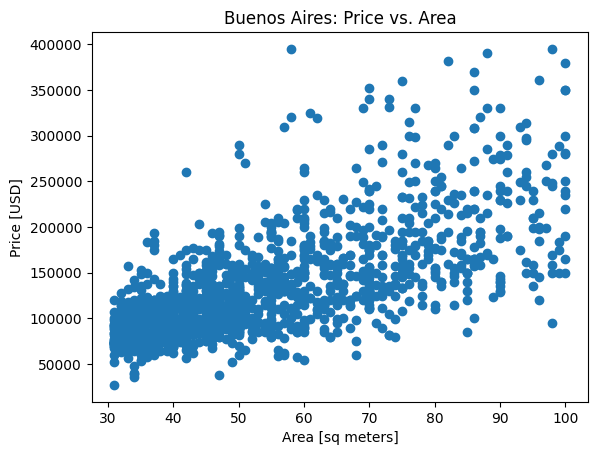

In [5]:
plt.scatter(x=df['surface_covered_in_m2'], y=df['price_aprox_usd'])
plt.xlabel('Area [sq meters]')
plt.ylabel('Price [USD]')
plt.title('Buenos Aires: Price vs. Area');

Este gráfico sugere que há uma correlação positiva moderada entre o preço do apartamento e o tamanho. Isso significa que, se o que queremos prever é o preço, o tamanho será um bom recurso a ser incluído.

### Split

Uma parte fundamental em qualquer projeto de construção de modelo é separar o seu alvo (o que você deseja prever) das suas características (as informações que o seu modelo usará para fazer suas previsões). Para este projeto, usaremos apenas uma característica: o tamanho do apartamento.

Criando a matriz de características chamada X_train, que sera usada para treinar o modelo. Ela contém apenas uma característica: ["surface_covered_in_m2"].

In [6]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(1343, 1)

Agora que temos os recursos, o próximo passo é criar um alvo.

Criando o vetor-alvo chamado y_train, que sera usado para treinar o modelo. O alvo deve ser "price_aprox_usd".

In [7]:
target = "price_aprox_usd"
y_train = df[target]
y_train.shape

(1343,)

### Contrução do modelo base

Baseline

O primeiro passo na construção de um modelo é a definição da linha de base. Para isso, pergunte-se: "Como saber se o modelo que se está construindo está tendo um bom desempenho?" Uma maneira de pensar sobre isso é ver como um modelo "sem valor" se comportaria com os mesmos dados. Algumas pessoas também chamam isso de modelo ingênuo ou de linha de base, mas um modelo sempre faz apenas uma previsão, neste caso, ele prevê o mesmo preço, independentemente do tamanho do apartamento. Então, vamos começar descobrindo qual deve ser a previsão do nosso modelo de linha de base.

* Calculando a média do vetor alvo y_train e atribuindo à variável y_mean.

In [8]:
y_mean = y_train.mean()
y_mean

np.float64(135527.83871928515)

Agora que temos a única previsão que nosso modelo burro sempre fará, precisamos gerar uma lista que repita a previsão para cada observação em nosso conjunto de dados.

* Criando uma lista chamada y_pred_baseline que contenha o valor de y_mean repetido para que tenha o mesmo comprimento em y.

In [9]:
y_pred_baseline = [y_mean] * len(y_train)

Então, como está o desempenho do nosso modelo base? Uma maneira de avaliá-lo é plotá-lo sobre o gráfico de dispersão que criamos acima.

* Adicionando uma linha ao gráfico abaixo que mostre a relação entre as observações X_train e as previsões y_pred_baseline do nosso modelo burro.

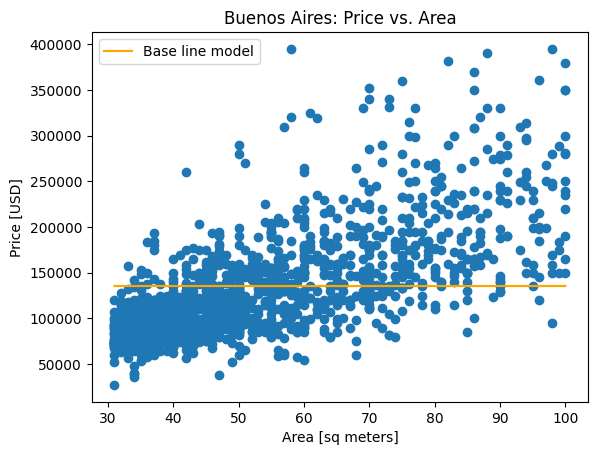

In [10]:
plt.plot(X_train.values, y_pred_baseline, color='orange', label='Base line model')
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

Observando esta visualização, parece que nosso modelo base não segue realmente a tendência dos dados. Mas, como cientista de dados, não se pode depender apenas de um gráfico subjetivo para avaliar um modelo. É necessário uma métrica de desempenho exata e matematicamente calculada. Existem muitas métricas de desempenho, mas a que usaremos aqui é o erro absoluto médio (mean absolute error).

* Calculando o erro absoluto médio da linha de base para as previsões em y_pred_baseline em comparação com os alvos reais em y.

In [11]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 135527.84
Baseline MAE: 45199.46


O que essa informação nos diz? Se sempre previmos que o preço de um apartamento é de US\$ 135.527,84, nossas previsões estariam erradas em uma média de US\$ 45.199,46. Elas também nos dizem que nosso modelo precisa ter um erro absoluto médio abaixo de US\$ 45.199,46 para ser útil.

### Iterate - Criação do modelo de machine learnig para previsão dos preços

O próximo passo na construção de um modelo é a iteração. Isso envolve construir um modelo, treiná-lo, avaliá-lo e, em seguida, repetir o processo até que estejamos satisfeito com o desempenho do modelo. Embora o modelo que estamos construindo seja linear, o processo de iteração raramente segue uma linha reta.

A primeira coisa que precisamos fazer é criar nosso modelo — neste caso, um que use regressão linear.

* Instanciando um modelo de Regressão Linear chamado model.

In [12]:
model = LinearRegression()

A segunda coisa que precisamos fazer é usar nossos dados para treinar nosso modelo. Outra maneira de dizer isso é ajustar nosso modelo aos dados de treinamento.

* Ajustando o modelo aos dados, X_train e y_train.

In [13]:
model.fit(X_train, y_train)

LinearRegression()

In [14]:
check_is_fitted(model)

### Evaluate

A etapa final é avaliar nosso modelo. Para isso, começaremos verificando seu desempenho ao fazer previsões com base nos dados obtidos durante o treinamento. Vamos então fazer com que ele preveja o preço das casas em nosso conjunto de treinamento.

* Usando o método de previsão do nosso modelo, vamos criar uma lista de previsões para as observações na nossa matriz de características X_train.

In [15]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

Agora que temos as previsões, vamos usá-las para avaliar o desempenho do nosso modelo com os dados de treinamento. Usaremos a mesma métrica que usamos para avaliar nosso modelo de base: erro absoluto médio (mean absolute error).

* Calcule o erro absoluto médio de treinamento para suas previsões em y_pred_training em comparação com os alvos reais em y_train.

In [16]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26


Boas notícias: nosso modelo superou a linha de base em mais de US\$ 10.000! Isso é um bom indicador de que será útil na previsão de preços de apartamentos. Mas o verdadeiro teste é como o modelo se comporta em dados que ele nunca viu antes, dados que chamamos de conjunto de teste

* Executando o código abaixo, importaremos os dados de teste buenos-aires-test-features.csv para um DataFrame e gerar uma série de previsões usando o modelo. Em seguida, calcularemos o MAE.

In [30]:
df_teste = wrangle('/content/buenos-aires-test-features.csv')
X_test = df_teste[features]
y_test = df_teste[target]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

,0
0,90292.590518
1,214214.320608
2,85786.345787
3,85786.345787
4,99305.079979


In [31]:
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Training MAE:", round(mae_test, 2))

Training MAE: 29199.28


Em geral, queremos que as métricas de desempenho dos teste sejam as mesmas que as métricas de desempenho do treinamento. Na prática, as métricas de teste tendem a ser um pouco piores (isso significa um número maior no caso do erro médio absoluto). Para nossa surpresa, o modelo apresnta uma média melhor nos dados de teste. Mas, desde que os desempenhos do treinamento e do teste sejam próximos, podemos ter certeza de que o modelo generalizará bem.

### Comunicando resultados

Agora que o modelo está pronto, é hora de compartilhá-lo com outras pessoas. Como estamos tratando de uma regressão linear e considerando que vamos apresentar os resultados para um píblico técnico, eles podem gostar de uma equação. Quando criamos nosso modelo base, o representamos como uma reta. A equação para uma reta como esta geralmente é escrita como:

y = ax + b.

y = Preço do apartamento

a = coeficiente

x = surface covered

b = intercepção

* Extrai a interceptação do seu modelo e atribui à variável intercept.

In [32]:
intercept = round(model.intercept_, 2)
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 11433.31


* Em seguida, vem o coeficiente. Vamos extraí-lo de maneira bem semelhante.

In [33]:
coefficient = round(model.coef_[0], 2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model coefficient for "surface_covered_in_m2": 2253.12


* Agora que temos nossa interceptação e coeficiente, precisamos inseri-los em uma string para podermos imprimir a equação completa.

In [34]:
print(f'apt_price = {intercept} + {coefficient} * surface_covered')

apt_price = 11433.31 + 2253.12 * surface_covered


Uma equação pode funcionar para alguns públicos técnicos, mas a visualização é uma ferramenta de comunicação muito mais eficaz — especialmente para públicos não técnicos. Então, vamos usar o gráfico de dispersão que fizemos no início desta lição e traçar a reta que essa equação formaria.

* Adicionando uma linha ao gráfico abaixo que mostra a relação entre as observações em X_train e as previsões do seu modelo y_pred_training.

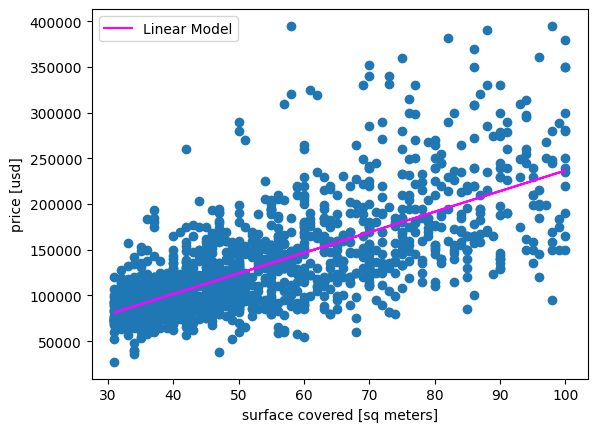

In [35]:
plt.plot(X_train.values, model.predict(X_train), color='magenta', label='Linear Model')
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();